In [11]:
# If you don't have these, run once in a cell: 
# !pip install pandas numpy matplotlib dataframe-image pillow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# —— paths ——
ROOT = Path(".")  # run notebook from your project root
DATA = ROOT / "out" / "torsion360" / "txt"   # folder with ALLMODELS_torsion360_clean.csv
ALLMODELS_FILE = DATA / "ALLMODELS_torsion360_clean.csv"  # change if yours is elsewhere

PLOTS_DIR = ROOT / "out" / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

TABLES_DIR = ROOT / "out"
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# —— analysis options ——
DATASET_TAG = "6d2u"       # we will keep only rows whose model name contains this
FOCUS_CHAIN = "B"          # set to None to use all chains
FOCUS_RANGE = (19, 43)     # set to None to use all residues
TORSIONS = ["alpha","beta","gamma","delta","epsilon","zeta","chi","phase-angle"]


In [12]:
df_all = pd.read_csv(ALLMODELS_FILE)

# keep only 6D2U models (case-insensitive)
df = df_all[df_all["model"].str.contains(DATASET_TAG, case=False, na=False)].copy()

# optional focus window
mask = pd.Series(True, index=df.index)
if FOCUS_CHAIN is not None:
    mask &= (df["chain"].fillna(FOCUS_CHAIN) == FOCUS_CHAIN)
if FOCUS_RANGE is not None:
    lo, hi = FOCUS_RANGE
    mask &= df["resi"].between(lo, hi)

df = df[mask].reset_index(drop=True)

print(f"Rows after filtering to {DATASET_TAG}: {len(df)}")
print("Unique models:", sorted(df["model"].str.extract(r'(.*?)(?:\.torsion360|$)')[0].unique().tolist())[:5], "…")
df.head(3)


Rows after filtering to 6d2u: 250
Unique models: ['6d2u_model01', '6d2u_model02', '6d2u_model03', '6d2u_model04', '6d2u_model05'] …


,model,chain,resn,resi,alpha,beta,gamma,delta,epsilon,zeta,chi,phase-angle
0,6d2u_model01,B,C,19,-65.6,170.1,55.1,82.5,-154.4,-70.0,-158.3,29.0
1,6d2u_model01,B,A,20,-65.8,172.3,54.3,81.9,-154.2,-71.2,-158.1,26.2
2,6d2u_model01,B,G,21,-66.5,169.9,54.3,82.7,-154.2,-68.9,-158.4,32.9


In [13]:
def circular_sd_deg(deg_vals):
    vals = np.deg2rad(np.asarray(deg_vals, dtype=float))
    if len(vals) < 2:
        return np.nan
    C = np.mean(np.cos(vals)); S = np.mean(np.sin(vals))
    R = np.hypot(C, S)
    if R <= 0:
        return 180.0/np.sqrt(3.0)  # ~103.92°
    return np.degrees(np.sqrt(-2.0*np.log(R)))


In [14]:
g = df.groupby(["chain","resi"], sort=True)

# SD per torsion via circular stats
sd_cols = {}
for t in TORSIONS:
    sd_cols[f"{t}_sd"] = g[t].apply(lambda x: circular_sd_deg(x.dropna()))

flex = pd.DataFrame(sd_cols).reset_index()

# find top-angle and max_sd per residue
sd_only = flex[[c for c in flex.columns if c.endswith("_sd")]]
angle_names = [c.replace("_sd","") for c in sd_only.columns]
top_idx = sd_only.values.argmax(axis=1)
flex["top_angle"] = [angle_names[i] if np.isfinite(sd_only.iloc[j,i]) else np.nan
                     for j,i in enumerate(top_idx)]
flex["max_sd"] = sd_only.max(axis=1)

flex = flex.sort_values(["chain","resi"]).reset_index(drop=True)

# save table (tagged with dataset name)
out_csv = TABLES_DIR / f"ensemble_flexibility_summary_{DATASET_TAG}.csv"
flex.to_csv(out_csv, index=False)
out_csv


WindowsPath('out/ensemble_flexibility_summary_6d2u.csv')

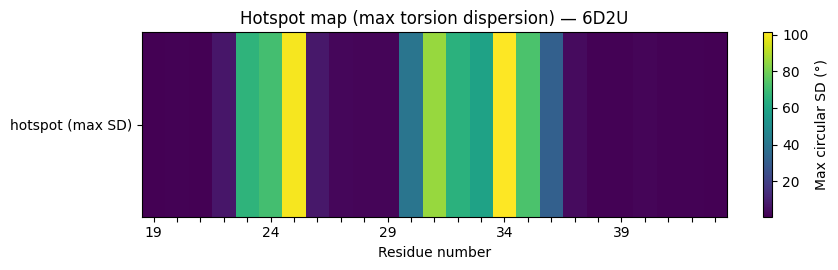

WindowsPath('out/plots/hotspot_map_maxsd_6d2u.png')

In [15]:
res_nums = flex["resi"].tolist()
maxsd    = flex["max_sd"].to_numpy()

plt.figure(figsize=(max(8, len(res_nums)/2.8), 2.8))
plt.imshow(maxsd.reshape(1, -1), aspect="auto", interpolation="nearest")
plt.colorbar(label="Max circular SD (°)")
plt.yticks([0], ["hotspot (max SD)"])
plt.xticks(range(len(res_nums)), res_nums)

# show only every 5th x label (but keep tick marks at each residue)
for i, lbl in enumerate(plt.gca().get_xticklabels()):
    lbl.set_visible((i % 5) == 0)

plt.xlabel("Residue number")
plt.title(f"Hotspot map (max torsion dispersion) — {DATASET_TAG.upper()}")
plt.tight_layout()

hotspot_png = PLOTS_DIR / f"hotspot_map_maxsd_{DATASET_TAG}.png"
plt.savefig(hotspot_png, dpi=300, bbox_inches="tight")
plt.show()

hotspot_png


In [21]:
flex.nlargest(10, "max_sd")[["chain","resi","top_angle","max_sd"]]


,chain,resi,top_angle,max_sd
15,B,34,chi,101.189921
6,B,25,alpha,99.870720
12,B,31,zeta,85.706508
16,B,35,alpha,72.748251
5,B,24,gamma,71.027328
4,B,23,alpha,66.255013
13,B,32,zeta,64.752076
14,B,33,alpha,58.467371
11,B,30,phase-angle,39.866317
17,B,36,alpha,31.411029
